# Data Wrangling

In [1]:
import pandas as pd
import requests
import json
import numpy as np
from tqdm.auto import tqdm
import datetime

# Import CANVAS_API_KEY from the .env file
from dotenv import load_dotenv
load_dotenv(verbose=True)

import os
API_KEY = os.getenv("CANVAS_API_KEY")
BASE_URL = os.getenv("CANVAS_BASE_URL")

In [2]:
def my_request(API_URL):
    headers = {'Authorization': 'Bearer '+ API_KEY}
    r = requests.get(BASE_URL+API_URL, headers=headers)
    return r.json()

def get_required_submissions_ids(course_id) : 
    '''extracts the required course ids for the course returns two dataframes:
    - required_assignments
    - capstones
    each with two columns 'id' and 'name' 
    example usage: 
        required_assignments, capstones = get_required_submissions_ids(course_id) '''
    
    r = my_request('/api/v1/courses/{}/assignments?per_page=200'.format(course_id))
    all_assignments = pd.DataFrame(r)
    required_assignments = all_assignments[all_assignments.name.str.contains('Assignment')]
    required_assignments = required_assignments[~required_assignments.name.str.contains('Capstone')]
    capstones = all_assignments[all_assignments.name.str.contains('Capstone')]
    return required_assignments[['id','name']], capstones[['id','name']]

# need to get only active students!! course 1682 failing at student 72758
def get_list_of_students(course_id) : 
    '''get the list of students in a panda series.
    Excample usage:
    student_ids = get_list_of_students(course_id)'''
    
    r = my_request('/api/v1/courses/{}/enrollments?type[]=StudentEnrollment&state[]=active&per_page=200'.format(course_id))
    
    return pd.DataFrame.from_dict(r)['user_id']


def check_student_passing_criteria(student_id, course_id, required_assignments, capstones) :
    '''checks if the student passed or failed the course. returns boolean'''
    r = my_request('/api/v1/courses/{}/students/submissions?student_ids[]={}&per_page=200'.format(course_id,student_id))
    student_submissions = pd.DataFrame.from_dict(r)[['grade','assignment_id','late','missing','seconds_late']] #could reduce to 'assignment_id' and 'grade'
    student_submissions['grade'].replace(to_replace='complete',value=1, inplace=True)
    student_submissions['grade'].replace(to_replace='incomplete',value=0, inplace=True)
    student_submissions['grade'].fillna(0,inplace=True)
    student_submissions['grade'] = student_submissions['grade'].astype(int) #convert boolean to int
    #student_submissions['late'] = student_submissions['late'].astype(int) # not needed as of right now. could check if too late...
    #student_submissions['missing'] = student_submissions['missing'].astype(int)
    
    capstone_check = pd.merge(student_submissions, capstones, left_on='assignment_id', right_on='id', how='inner')['grade'].sum()
    if capstone_check >= 1 : 
        # meets the capstone passing criteria
        # checking the next criteria
        assignment_check = pd.merge(student_submissions, required_assignments, left_on='assignment_id', right_on='id', how='inner')['grade'].sum()
        if assignment_check >= 7 :
            # meets both criterias --> pass
            return True
    else :
        # didn't meet at least one criteria
        return False

# calculate pass fail for entire course
def check_passing_criteria_from_course_id(course_id, verbose=0) :
    '''gets student pass fail for entire course'''
    outcomes = pd.DataFrame(columns = ['student_id', 'course_id', 'outcome'])
    # get list of required assignments
    print('Getting list of required assignments...', end=" ")
    required_assignments, capstones = get_required_submissions_ids(course_id)
    print('DONE')
    
    # get list of students
    print('Getting list of students...', end=" ")
    student_ids = get_list_of_students(course_id)
    print('DONE')
    
    print('Checking every single student...')
    for s_id in student_ids :
        outcome = check_student_passing_criteria(s_id, course_id, required_assignments, capstones)
        outcomes = outcomes.append({'student_id' : s_id, 'course_id':course_id, 'outcome':outcome},ignore_index=True)
        if verbose == 1 :
            print(s_id, end=" ")
            print(outcome)
        else :
            print("|", end="")
    print(' DONE\n')
        
    return outcomes

# get cutoff date for course
def get_cutoff_date(course_id, cutoff_assignment = 'Assignment 4.1'):
                                     
    r = my_request('/api/v1/courses/{}/assignments?per_page=200'.format(course_id))
    df = pd.json_normalize(r)
    date_df = df[df['name'].str.startswith(cutoff_assignment)]
    cutoff_date = date_df.iloc[0]['discussion_topic.posted_at']
    #print(cutoff_date)
    pd.to_datetime(cutoff_date)
    cutoff_date = pd.to_datetime(cutoff_date)+datetime.timedelta(days=8)
    return cutoff_date

In [3]:
# get relevant course_ids
r = my_request('/api/v1/courses?enrollment_type=teacher')

response= pd.DataFrame.from_dict(r)
course_ids = response[response['name'].str.contains('AI')]['id']

## Create Outcome Variable: check pass fail for the entire course

In [4]:
outcomes = pd.DataFrame(columns = ['student_id', 'course_id', 'outcome'])

for c in course_ids :
    outcomes = outcomes.append(check_passing_criteria_from_course_id(c, verbose=0))

outcomes.to_csv('../data/outcomes.csv')

Getting list of required assignments... DONE
Getting list of students... DONE
Checking every single student...
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| DONE

Getting list of required assignments... DONE
Getting list of students... DONE
Checking every single student...
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| DONE

Getting list of required assignments... DONE
Getting list of students... DONE
Checking every single student...
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| DONE

Getting list of required assignments... DONE
Getting list of students... DONE
Checking every single student...
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| DONE

Getting list of required assignments... DONE
Getting list of students... DONE
Checking every single student...
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [5]:
outcomes.head()

,student_id,course_id,outcome
0,47649,1116,True
1,52263,1116,True
2,24036,1116,True
3,52137,1116,True
4,52267,1116,True


In [6]:
outcomes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 0 to 76
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   student_id  425 non-null    object
 1   course_id   425 non-null    object
 2   outcome     422 non-null    object
dtypes: object(3)
memory usage: 13.3+ KB


## Create Features : getting student activity

In [7]:
# get student data for entire course
def get_student_data_until_cutoff(student_id, course_id, cutoff_date) :
    '''get data for single student until cutoff date'''
    
    r = my_request('/api/v1/courses/{}/analytics/users/{}/activity?per_page=200'.format(course_id,student_id))
    #creates data structure for page_views
    df =pd.DataFrame.from_dict((r['page_views']),orient='index')
    if df.empty :
        #insert dummy pageviews to make formulas work
        df = pd.DataFrame(columns = pd.RangeIndex(start=0, stop=1, step=1), index = [cutoff_date]).fillna(0)
    df.index = pd.to_datetime(df.index)
    df.columns = ['page_views']
    #creates data sctructure for participations
    df2 = pd.DataFrame.from_dict(r['participations'])
    if df2.empty :
        # insert dummy participation to make formulas work
        df2 = pd.DataFrame({'created_at':cutoff_date, 'url':'NaN'}, index=['created_at'])
    df2.set_index('created_at', inplace=True)
    df2.index = pd.to_datetime(df2.index)
    data = pd.DataFrame({
        'student_id' : student_id,
        'course_id' : course_id,
        'tot_page_views': df[:cutoff_date].sum()[0],
        'average_daily_views' : np.mean(df[:cutoff_date].resample('D').sum())[0],
        'median_daily_views' : np.median(df[:cutoff_date].resample('D').sum()),
        'max_daily_views' : np.max(df[:cutoff_date].resample('D').sum())[0],
        'days_with_views' :len(df[:cutoff_date].resample('D').sum()),
        'hours_with_views' : len(df[:cutoff_date]),
        'max_views_per_hour' : np.max(df[:cutoff_date])[0],
        'avg_views_per_hour' : np.mean(df[:cutoff_date])[0],
        'median_views_per_hour' : np.median(df[:cutoff_date]),
        'avg_hours_with_views_per_day' : np.mean(df[:cutoff_date].resample('D').count())[0],
        'max_hours_with_views_per_day' : np.mean(df[:cutoff_date].resample('D').count())[0],
        'median_hours_with_views_per_day' : np.median(df[:cutoff_date].resample('D').count()),
        'tot_participations' : len(df2[:cutoff_date]),
        'average_daily_participations' : np.mean(df2[:cutoff_date].resample('D').count())[0],
        'median_daily_participations' : np.median(df2[:cutoff_date].resample('D').count()),
        'max_daily_participations' : np.max(df2[:cutoff_date].resample('D').count())[0],
        'days_with_participations' : len(df2[:cutoff_date].resample('D').count())                     
    }, index=[student_id],)
    return data


def get_students_data_from_course_id(course_id, verbose=0) :
    '''gets students data for entire course'''
    features = pd.DataFrame() # Columns name necessary???
    print(f"Extracting data from course {course_id}.")
    # get list of students
    print('Getting list of students...', end=" ")
    student_ids = get_list_of_students(course_id)
    print('DONE')
    
    # get cutoff date
    print('Getting cutoff date...', end=" ")
    cutoff_date = get_cutoff_date(course_id, cutoff_assignment = 'Assignment 4.1')
    print('DONE')
    
    print('Getting data for each student...')
    for s_id in student_ids :
        if verbose == 1 :
            print(f"Student {s_id}...", end=" ")
        else :
            print("|", end="")
        features = features.append(get_student_data_until_cutoff(s_id, course_id, cutoff_date))
        if verbose == 1 : print(' DONE')
    print(' DONE\n')
        
    return features

In [10]:
features = pd.DataFrame()

for c in course_ids :
    features = features.append(get_students_data_from_course_id(c, verbose=0))
    
features.to_csv('../data/features.csv')

Extracting data from course 1116.
Getting list of students... DONE
Getting cutoff date... DONE
Getting data for each student...
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

/home/andrea/anaconda3/envs/student-fail-prediction/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andrea/anaconda3/envs/student-fail-prediction/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


|| DONE

Extracting data from course 1202.
Getting list of students... DONE
Getting cutoff date... DONE
Getting data for each student...
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| DONE

Extracting data from course 1394.
Getting list of students... DONE
Getting cutoff date... DONE
Getting data for each student...
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| DONE

Extracting data from course 1574.
Getting list of students... DONE
Getting cutoff date... DONE
Getting data for each student...
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| DONE

Extracting data from course 1682.
Getting list of students... DONE
Getting cutoff date... DONE
Getting data for each student...
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| DONE



In [11]:
features.head()

,student_id,course_id,tot_page_views,average_daily_views,median_daily_views,max_daily_views,days_with_views,hours_with_views,max_views_per_hour,avg_views_per_hour,median_views_per_hour,avg_hours_with_views_per_day,max_hours_with_views_per_day,median_hours_with_views_per_day,tot_participations,average_daily_participations,median_daily_participations,max_daily_participations,days_with_participations
47649,47649,1116,1153,22.607843,16.0,118.0,51,71,88.0,16.239437,15.0,1.392157,1.392157,1.0,23,0.460000,0.0,4.0,50
52263,52263,1116,744,15.183673,0.0,93.0,49,67,48.0,11.104478,8.0,1.367347,1.367347,0.0,20,0.434783,0.0,3.0,46
24036,24036,1116,341,6.686275,0.0,80.0,51,27,48.0,12.629630,11.0,0.529412,0.529412,0.0,15,0.333333,0.0,3.0,45
52137,52137,1116,237,5.042553,0.0,68.0,47,19,32.0,12.473684,9.0,0.404255,0.404255,0.0,6,0.187500,0.0,3.0,32
52267,52267,1116,665,13.300000,0.0,161.0,50,42,118.0,15.833333,8.0,0.840000,0.840000,0.0,26,0.520000,0.0,5.0,50


In [12]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 47649 to 81394
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   student_id                       425 non-null    int64  
 1   course_id                        425 non-null    int64  
 2   tot_page_views                   425 non-null    int64  
 3   average_daily_views              422 non-null    float64
 4   median_daily_views               422 non-null    float64
 5   max_daily_views                  422 non-null    float64
 6   days_with_views                  425 non-null    int64  
 7   hours_with_views                 425 non-null    int64  
 8   max_views_per_hour               422 non-null    float64
 9   avg_views_per_hour               422 non-null    float64
 10  median_views_per_hour            422 non-null    float64
 11  avg_hours_with_views_per_day     422 non-null    float64
 12  max_hours_with_v

## Potential additional features: student assignements and ontime performance
In second iteration we could expand the input data by constructing more features:
- time between publish date and participation
- time before or after deadline
- (hour of the day, day of the week.. could require timezone info of the student...)

In [13]:
#get list of assignments per student
course_id = '1574'
student_id = '71164'

r = my_request('/api/v1/courses/{}/students/submissions?student_ids[]={}&per_page=200'.format(course_id,student_id))

In [14]:
pd.DataFrame.from_dict(r)[['grade','assignment_id','late','missing','seconds_late']].head()

,grade,assignment_id,late,missing,seconds_late
0,complete,63387,False,False,0
1,complete,63388,False,False,0
2,complete,63389,False,False,0
3,complete,63390,False,False,0
4,complete,63391,False,False,0


In [15]:
student_submissions = pd.DataFrame.from_dict(r)[['grade','assignment_id','late','missing','seconds_late']]
student_submissions['grade'].replace(to_replace='complete',value=1, inplace=True)
student_submissions['grade'].fillna(0,inplace=True)
student_submissions['grade'] = student_submissions['grade'].astype(int) #convert boolean to int
student_submissions['late'] = student_submissions['late'].astype(int)
student_submissions['missing'] = student_submissions['missing'].astype(int)
student_submissions

,grade,assignment_id,late,missing,seconds_late
0,1,63387,0,0,0
1,1,63388,0,0,0
2,1,63389,0,0,0
3,1,63390,0,0,0
4,1,63391,0,0,0
5,1,63392,0,0,0
6,1,63393,0,0,0
7,1,63396,1,0,1205
8,0,63676,0,1,11144644
9,0,63679,0,1,9935044


This student submission could be transposed to create one feature per assignment id (match assignment id with name to merge across many courses).

# Exploratoy Data Analysis

In [16]:
from src.MyAutoEDA import *

In [17]:
with open('../data/features.csv') as f1:
    df = pd.read_csv(f1)

with open('../data/outcomes.csv') as f2:
    outcomes = pd.read_csv(f2, usecols=['student_id', 'outcome'])
                           
df = pd.merge(df, outcomes, on='student_id')
 

df.drop(['Unnamed: 0', 'course_id', 'student_id'], axis='columns', inplace=True)

In [18]:
df.head()

,tot_page_views,average_daily_views,median_daily_views,max_daily_views,days_with_views,hours_with_views,max_views_per_hour,avg_views_per_hour,median_views_per_hour,avg_hours_with_views_per_day,max_hours_with_views_per_day,median_hours_with_views_per_day,tot_participations,average_daily_participations,median_daily_participations,max_daily_participations,days_with_participations,outcome
0,1153,22.607843,16.0,118.0,51,71,88.0,16.239437,15.0,1.392157,1.392157,1.0,23,0.460000,0.0,4.0,50,True
1,744,15.183673,0.0,93.0,49,67,48.0,11.104478,8.0,1.367347,1.367347,0.0,20,0.434783,0.0,3.0,46,True
2,341,6.686275,0.0,80.0,51,27,48.0,12.629630,11.0,0.529412,0.529412,0.0,15,0.333333,0.0,3.0,45,True
3,237,5.042553,0.0,68.0,47,19,32.0,12.473684,9.0,0.404255,0.404255,0.0,6,0.187500,0.0,3.0,32,True
4,665,13.300000,0.0,161.0,50,42,118.0,15.833333,8.0,0.840000,0.840000,0.0,26,0.520000,0.0,5.0,50,True


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 0 to 424
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   tot_page_views                   425 non-null    int64  
 1   average_daily_views              422 non-null    float64
 2   median_daily_views               422 non-null    float64
 3   max_daily_views                  422 non-null    float64
 4   days_with_views                  425 non-null    int64  
 5   hours_with_views                 425 non-null    int64  
 6   max_views_per_hour               422 non-null    float64
 7   avg_views_per_hour               422 non-null    float64
 8   median_views_per_hour            422 non-null    float64
 9   avg_hours_with_views_per_day     422 non-null    float64
 10  max_hours_with_views_per_day     422 non-null    float64
 11  median_hours_with_views_per_day  422 non-null    float64
 12  tot_participations    

ValueError: invalid literal for int() with base 10: 'True'

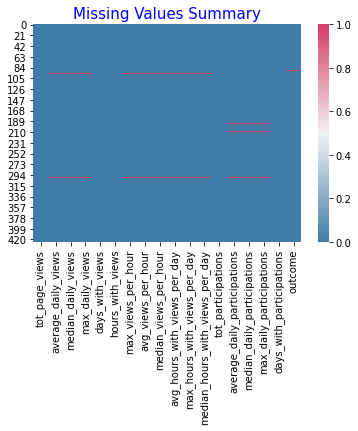

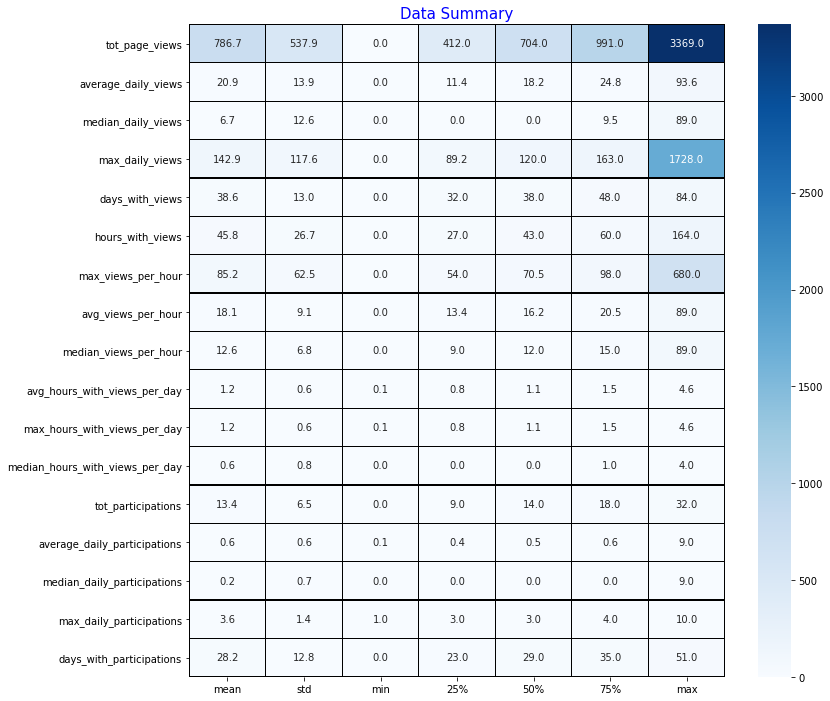

In [20]:
labels = ['fail', 'pass']
target_variable_name = 'outcome'

EDA(df,labels,target_variable_name,
        data_summary_figsize=(12,12),corr_matrix_figsize=(12,12),
        data_summary_figcol="Blues",corr_matrix_figcol='Blues',
        corr_matrix_annot=True,
        pairplt_col='all',pairplt=False,
        feature_division_figsize=(12,12))